<a href="https://colab.research.google.com/github/dnguyend/par-trans/blob/main/examples/NumpyFlagParallel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workbook to test Flag parallel transport using numpy

This should be run under CPU run time. Flag manifold is with the canonical metric.


In [ ]:
#@title Imports & Utils
import ipywidgets as widgets
from IPython.display import display
import subprocess


class credentials_input():
    """To access a private repository
    Include this snippet of codes to colab if you want to access
    a private repository
    """
    def __init__(self, repo_name):
        self.repo_name = repo_name
        self.username = widgets.Text(description='Username', value='')
        self.pwd = widgets.Password(
            description='Password', placeholder='password here')

        self.username.on_submit(self.handle_submit_username)
        self.pwd.on_submit(self.handle_submit_pwd)
        display("Use %40 for @ in email address:")
        display(self.username)

    def handle_submit_username(self, text):
        display(self.pwd)

    def handle_submit_pwd(self, text):
        username = self.username.value.replace('@', '%40')
        # cmd = f'git clone https://{username}:{self.pwd.value}@{self.repo_name}'
        cmd = f'pip install git+https://{username}:{self.pwd.value}@{self.repo_name}'
        process = subprocess.Popen(
            cmd.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        output, error = process.communicate()
        print(output, error)
        self.username.value, self.pwd.value = '', ''

credentials_input('github.com/dnguyend/par-trans.git')




May take a bit to download - after that you will see "Collecting git+..."

Import the libraries

In [ ]:
from time import perf_counter

import numpy as np
import numpy.linalg as la
from numpy.random import randn
import pandas as pd
from scipy.linalg import expm
import scipy.sparse.linalg as ssl

from par_trans.manifolds import Flag
from par_trans.manifolds import Stiefel
from par_trans.utils.utils import (sym, asym, cz, vcat)
import par_trans.utils.expm_multiply_np as enp


Run several tests:
* check the metric compatible condition of the Levi-Civita connection. For 2 tangent vectors $v, va$, $X: z\mapsto stf.proj(z, va)$ is a vector field. We compare $D_v\langle X, X\rangle$ and $2\langle X, D_vX + \Gamma(v, X)\rangle$
* Check Geodesic and transport equations.
* The function stf.exp gives the Riemannian exponential map, while $stf.dexp(x, v, t,ddexp=True) $ computes $\gamma(t), \dot{\gamma}(t)$ and $\ddot{\gamma}(t)$ where $\gamma(t)$ is the geodesic starting at $x$ with initial velocity $\dot{\gamma}(0) = v$. If $ddexp=False$, only $\gamma$ and $\dot{\gamma}$ are returned.

We verify dexp indeed returns the time derivatives, and show the parallel transport equation is satisfied. We also show parallel transport with the customized solve_w (stf.paralle) is much faster than parallel transport using scipy expm_multiply, although numerically they are the same.


In [ ]:
def test_big():
    np.random.seed(0)
    n = 300
    d = 200
    dvec = np.array([50, 20, 30, 200])

    alp = .5
    flg = Flag(dvec, alp)

    x = flg.rand_point()
    v = flg.rand_vec(x)
    va = flg.rand_vec(x)
    # c = stf.rand_vec(np.eye(n)[:, :d])

    dlt = 1e-6
    t = .8
    print("CHECK METRIC COMPATIBILITY USING NUMERICAL DERIVATIVE")
    print((flg.inner(x+dlt*v, flg.proj(x+dlt*v, va), flg.proj(x+dlt*v, va)) - flg.inner(x, va, va))/dlt)
    print(2*flg.inner(x, va, (flg.proj(x+dlt*v, va) -va)/dlt + flg.christoffel_gamma(x, v, va)))

    r1 = (flg.proj(x+dlt*v, va) - flg.proj(x, va))/dlt + flg.christoffel_gamma(x, v, va)
    print("Check Christoffel gamma produces a connection")
    print(cz(flg.symf(x.T@r1)))

    r1 = flg.exp(x, t*v)

    print("Check time derivatives of geodesics")
    print(np.allclose((flg.exp(x, (t+dlt)*v) - flg.exp(x, t*v))/dlt,
                      flg.dexp(x, v, t, ddexp=False)[1], atol=1e-3
                      ))

    print(np.allclose((flg.dexp(x, v, t+dlt)[1] - flg.dexp(x, v, t)[1])/dlt,
                      flg.dexp(x, v, t, ddexp=True)[2], atol=1e-2
                      ))

    gmms = flg.dexp(x, v, t, ddexp=True)

    print("CHECK Geodesic Equation with analytic differentiation")
    print(cz(gmms[2] + flg.christoffel_gamma(gmms[0], gmms[1], gmms[1])))

    t0 = perf_counter()
    Delta1 = flg.parallel_canonical_expm_multiply(x, v, va, t)
    t1 = perf_counter()
    Delta = flg.parallel_canonical(x, v, va, t)

    t2 = perf_counter()
    print(cz(Delta-Delta1))
    print("time expm_multiply =%f(s), time solv_w = %f(s)" % (t1 - t0, t2-t1))
    print("CHECK TRANSPORT EQUATION with numerical differentiation")
    print(cz((flg.parallel_canonical(x, v, va, t+dlt) - Delta)/dlt \
          + flg.christoffel_gamma(gmms[0], gmms[1], Delta)))
test_big()

CHECK METRIC COMPATIBILITY USING NUMERICAL DERIVATIVE
-400.57657679426484
-401.60745063913214
Check Christoffel gamma produces a connection
0.00020650823213408387
Check time derivatives of geodesics
True
True
CHECK Geodesic Equation with analytic differentiation
4.600764214046649e-13
1.149080830487037e-14
time expm_multiply =2.039003(s), time solv_w = 0.229920(s)
CHECK TRANSPORT EQUATION with numerical differentiation
0.0002820848326630099


A quick check on the speed of parallel.

In [ ]:
def check_time():
  dvec = np.array([50, 20, 30, 100, 100])
  alp = .5
  flg = Flag(dvec, alp)
  x = flg.rand_point()
  v = flg.rand_vec(x)
  v = v/np.sqrt(flg.inner(x, v, v))
  va = flg.rand_vec(x)
  for t in [.5, 1., 2., 10., 20.]:
    t0 = perf_counter()
    flg.parallel_canonical(x, v, va, t)
    t1 = perf_counter()
    print("t=%f time=%f(s)" % (t, t1-t0))
check_time()

t=0.500000 time=0.238864(s)
t=1.000000 time=0.261068(s)
t=2.000000 time=0.307214(s)
t=10.000000 time=0.445690(s)
t=20.000000 time=0.507720(s)


In [ ]:
def check_time_d():
  n = 1000
  dvec0 = np.array([5, 2, 3])
  dbase = dvec0.sum()
  t = 1.
  for d in [10, 20, 50, 100, 200, 500]:
    alp = .6
    dvec = np.concatenate([(d//dbase)*dvec0, np.array([n-d])])
    flg = Flag(dvec, alp)
    x = flg.rand_point()
    v = flg.rand_vec(x)
    v = v/np.sqrt(flg.inner(x, v, v))
    va = flg.rand_vec(x)
    t0 = perf_counter()
    flg.parallel_canonical(x, v, va, t)
    t1 = perf_counter()
    print("d=%d time=%f(s)" % (d, t1-t0))
check_time_d()

d=10 time=0.030436(s)
d=20 time=0.032662(s)
d=50 time=0.063192(s)
d=100 time=0.096215(s)
d=200 time=0.329002(s)
d=500 time=1.680297(s)


# Comparing against Stiefel

In [ ]:
def compare_Stiefel(t):
    print("Doing t=%f" % t)
    dvec = np.array([50, 20, 30, 100, 100])
    alp = .5
    flg = Flag(dvec, alp)

    stf = Stiefel(flg.shape[0], flg.shape[1], .5)

    x = flg.rand_point()
    v = flg.rand_vec(x)
    va = flg.rand_vec(x)

    t0 = perf_counter()
    stf.dexp(x, v, t, ddexp=True)[2]
    t1 = perf_counter()
    print("Stiefel geodesic time %f" % (t1-t0))

    t2 = perf_counter()
    flg.dexp(x, v, t, ddexp=True)[2]
    t3 = perf_counter()
    print("Flag geodesic time %f" % (t3-t2))

    t4 = perf_counter()
    stf.parallel(x, v, va, t)
    t5 = perf_counter()
    print("Stiefel parallel time %f" % (t5-t4))

    t6 = perf_counter()
    flg.parallel_canonical(x, v, va, t)
    t7 = perf_counter()
    print("Flag parallel time %f" % (t7-t6))

compare_Stiefel(t=.5)
compare_Stiefel(t=5)


Doing t=0.500000
Stiefel geodesic time 0.101302
Flag geodesic time 0.091461
Stiefel parallel time 0.882532
Flag parallel time 1.184924
Doing t=5.000000
Stiefel geodesic time 0.240027
Flag geodesic time 0.205279
Stiefel parallel time 5.593647
Flag parallel time 4.598521


# TEST ISOMETRY

We show the inner product metric is preserved to around $10^{-12}$ accuracy up to $t=15$. THis will take a while to run. THe graph in the paper comes from a different run, but is mostly compatible.  We note that if we run in higher dimension, the free colab sessions shows occasional spikes in error. This is not a problem in a local session with a high memory machine.

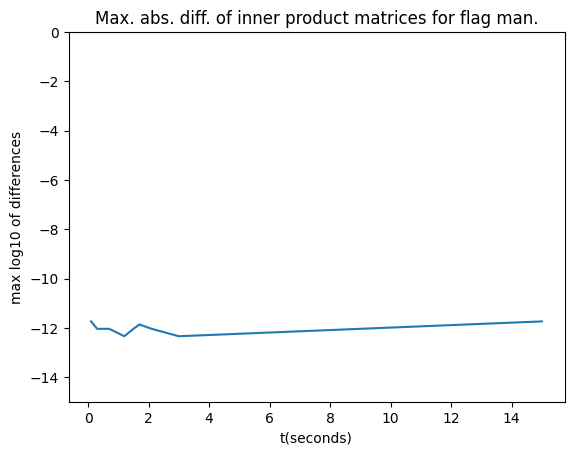

array([[  0.1       , -11.74016983],
       [  0.3       , -12.04119983],
       [  0.5       , -12.04119983],
       [  0.7       , -12.04119983],
       [  1.2       , -12.34222982],
       [  1.5       , -12.04119983],
       [  1.7       , -11.86510857],
       [  2.1       , -12.04119983],
       [  3.        , -12.34222982],
       [ 15.        , -11.74016983]])

In [ ]:
import matplotlib.pyplot as plt
import numpy.linalg as la

np.random.seed(0)
dvec = np.array([50, 20, 30, 1900])
alp = .5
flg = Flag(dvec, alp)
x = np.concatenate([np.eye(flg.shape[1]), np.zeros((flg.shape[0]-flg.shape[1], flg.shape[1]))])

n_samples = 20

all_smpl = []

def normalize(a, x):
    return a / np.sqrt(flg.inner(x, a, a))

for _ in range(n_samples):
    spl = flg.rand_vec(x)
    ft = np.random.choice(3*n_samples, (), replace=True)

    all_smpl.append(ft*normalize(spl, x))

all_smpl = np.array(all_smpl)


def cal_cov(gm, smpls):
    mat = np.zeros((n_samples,  n_samples))
    for i in range(n_samples):
        for j in range(i+1):
            mat[i, j] = flg.inner(gm, smpls[i, :, :], smpls[j, :, :])
            if i != j:
                mat[j, i] = mat[i, j]
    return mat

cov_0 = cal_cov(x, all_smpl)

v = flg.rand_vec(x)
v = v/np.sqrt(flg.inner(x, v, v))

cov_diff = []
# t_grid = [0.5, 1., 2., 5., 10., 15.]
# t_grid = [0.5, 1.]
t_grid = [0.1, .3, .5, .7, 1.2, 1.5, 1.7, 2.1, 3., 15.]
for t in t_grid:
    transported = []
    for i in range(n_samples):
        transported.append(flg.parallel_canonical(x, v, all_smpl[i, :, :], t))

    transported = np.array(transported)
    gm = flg.exp(x, t*v)
    cov_t = cal_cov(gm, transported)
    # print(cz(cov_t- cov_0))
    cov_diff.append((t, cov_t))

plt.plot(t_grid, [np.log10(cz(cov_diff[i][1] - cov_0)) for i in range(len(cov_diff))])
plt.ylim(-15, 0)
plt.xlabel("t(seconds)")
plt.ylabel("max log10 of differences")
plt.title("Max. abs. diff. of inner product matrices for flag man.")
plt.savefig("cov_diff_flag.png")
plt.show()
display(np.concatenate([np.array(t_grid)[:, None], np.array([np.log10(cz(cov_diff[i][1] - cov_0)) for i in range(len(cov_diff))])[:, None]], axis=1))

# Check effect of changing n, d, and t
This takes the most time. This may run faster on a machine with better hardware than on a free colab session.

In [ ]:
import pandas as pd
def test_one_set(flg, t_interval, n_samples=10, n_repeats=5):
    ret = []
    d = flg.shape[1]
    for _ in range(n_samples):
        ret_spl = []
        x = flg.rand_point()
        v = flg.rand_vec(x)
        va = flg.rand_vec(x)
        # compile the git
        flg.dexp(x, v, 1.)
        par = flg.parallel_canonical(x, v, va, 1.)
        dlt = 1e-7
        for t in t_interval:
            ret_t = []
            for _ in range(n_repeats):
                t0 = perf_counter()
                gmms = flg.dexp(x, v, t)
                t1 = perf_counter()
                t_gmms = t1 - t0

                t3 = perf_counter()
                par = flg.parallel_canonical(x, v, va, t)
                t4 = perf_counter()
                t_par = t4 - t3

                # check accuracy:
                geo_man = cz(gmms[0].T@gmms[0] - np.eye(d))
                par_tan = cz(sym(gmms[0].T@par))
                par_eq = cz((flg.parallel_canonical(x, v, va, t+dlt) - flg.parallel_canonical(x, v, va, t))/dlt +
                            flg.christoffel_gamma(gmms[0], gmms[1], par))

                ret_t.append([t_gmms, t_par, geo_man, par_tan, par_eq])


            ret_spl.append(ret_t)
        ret.append(ret_spl)

    return np.array(ret)


def test_time():
    t_interval = np.array([.5, 1., 2., 5., 20.])
    dparts = np.array([4, 3, 3])
    dbase = dparts.sum()

    # first test, fixed d = 100
    d_list = np.array([50])
    n_list = np.array([100, 200, 1000, 2000])
    # n_list = np.array([100])

    alp = .5

    all_ret_0 = {}
    for d in d_list:
        for n in n_list:
            print("Doing n=%d d=%d" % (n, d))
            if n <= d:
                continue

            dvec = np.concatenate([d//dbase*dparts, np.array([n - d])])
            flg = Flag(dvec, alp)
            ret = test_one_set(flg, t_interval, n_samples=5, n_repeats=2)
            all_ret_0[int(d), int(n)] = ret

    tbl = []
    for t_idx in range(t_interval.shape[0]):
        for idx, val in all_ret_0.items():
            tbl.append([idx[1], t_interval[t_idx]] + list(val[:, t_idx, :, :].mean(axis=((0, 1)))))

    raw_tbl = []
    for idx, val in all_ret_0.items():
        for t_idx in range(t_interval.shape[0]):
            for i_s in range(val.shape[0]):
                for i_r in range(val.shape[2]):
                    raw_tbl.append([idx[1], t_interval[t_idx]] + list(val[i_s, t_idx, i_r, :]))

    pd.DataFrame(raw_tbl).to_pickle('flg_by_n.pkl')

    # second test, fix n = 2000, test d = [5, 10, 20, 200, 500]

    d_list = np.array([10, 20, 100])
    # d_list = np.array([48])
    n_list = np.array([1000])


    all_ret_1 = {}
    for d in d_list:
        for n in n_list:
            print("Doing n=%d d=%d" % (n, d))
            if n <= d:
                continue
            dvec = np.concatenate([d//dbase*dparts, np.array([n - d])])
            flg = Flag(dvec, alp)
            ret = test_one_set(flg, t_interval, n_samples=5, n_repeats=2)
            all_ret_1[int(d), int(n)] = ret

    tbl1 = []
    for t_idx in range(t_interval.shape[0]):
        for idx, val in all_ret_1.items():
            tbl1.append([idx[0], t_interval[t_idx]] + list(val[:, t_idx, :, :].mean(axis=((0, 1)))))

    raw_tbl1 = []
    for idx, val in all_ret_1.items():
        for t_idx in range(t_interval.shape[0]):
            for i_s in range(val.shape[0]):
                for i_r in range(val.shape[2]):
                    raw_tbl1.append([idx[0], t_interval[t_idx]] + list(val[i_s, t_idx, i_r, :]))

    pd.DataFrame(raw_tbl1).to_pickle('flg_by_d_1000.pkl')
test_time()

Doing n=100 d=50
Doing n=200 d=50
Doing n=1000 d=50
Doing n=2000 d=50
Doing n=1000 d=10
Doing n=1000 d=20
Doing n=1000 d=100


In [ ]:
def display_test():
    import pandas as pd

    by_n_tbl = pd.read_pickle('flg_by_n.pkl')
    # by_n_tbl.iloc[:, 2:] = np.array(by_n_tbl.iloc[:, 2:])
    by_n_tbl.iloc[:, 1] = [f"{a:04.1f}" for a in by_n_tbl.iloc[:, 1].values]
    by_n_tbl.columns = ['n', 't', 'geo_time', 'par_time', 'err_geo', 'err_tan', 'err_eq']
    by_n_tbl['log_err_eq'] = [np.log10(a) for a in by_n_tbl.err_eq.values]

    by_n_prep = by_n_tbl.pivot_table(index='n',
                                     columns='t',
                                     values=['par_time', 'log_err_eq'],
                                     aggfunc='mean')
    def str1(a):
        return '%.1f' % a

    def str2(a):
        return '%.2f' % a

    print(by_n_prep.to_latex(formatters=5*[str1] + 5*[str2]))
    display(by_n_prep)
    # alp_tbl = jnp.array([.5, 1.])
    # by_n_tbl.loc[:, 'alp'] = alp_tbl[by_n_tbl.loc[:, 'alp'].values]
    by_d_tbl = pd.read_pickle('flg_by_d_1000.pkl')
    by_d_tbl.iloc[:, 1] = [f"{a:04.1f}" for a in by_d_tbl.iloc[:, 1].values]
    by_d_tbl.columns = ['d', 't', 'geo_time', 'par_time', 'err_geo', 'err_tan', 'err_eq']

    by_d_tbl['log_err_eq'] = [np.log10(a) for a in by_d_tbl.err_eq.values]

    by_d_prep = by_d_tbl.pivot_table(index='d',
                                     columns='t',
                                     values=['par_time', 'log_err_eq'],
                                     aggfunc='mean')

    print(by_d_prep.to_latex(formatters=5*[str1] + 5*[str2]))
    display(by_d_prep)
display_test()

\begin{tabular}{lrrrrrrrrrr}
\toprule
 & \multicolumn{5}{r}{log_err_eq} & \multicolumn{5}{r}{par_time} \\
t & 00.5 & 01.0 & 02.0 & 05.0 & 20.0 & 00.5 & 01.0 & 02.0 & 05.0 & 20.0 \\
n &  &  &  &  &  &  &  &  &  &  \\
\midrule
100 & -5.0 & -5.0 & -5.0 & -4.9 & -5.0 & 0.04 & 0.07 & 0.12 & 0.17 & 0.50 \\
200 & -4.7 & -4.7 & -4.7 & -4.7 & -4.7 & 0.06 & 0.10 & 0.16 & 0.23 & 0.56 \\
1000 & -4.3 & -4.3 & -4.3 & -4.3 & -4.3 & 0.11 & 0.17 & 0.21 & 0.34 & 1.33 \\
2000 & -4.2 & -4.2 & -4.1 & -4.2 & -4.2 & 0.23 & 0.27 & 0.32 & 0.54 & 1.60 \\
\bottomrule
\end{tabular}



log_err_eq                                          par_time            \
t          00.5      01.0      02.0      05.0      20.0      00.5      01.0   
n                                                                             
100   -4.984995 -4.989097 -5.022407 -4.946445 -4.974665  0.043302  0.071538   
200   -4.748904 -4.732082 -4.721644 -4.729571 -4.744618  0.059632  0.101157   
1000  -4.304858 -4.345278 -4.332519 -4.313452 -4.348398  0.114961  0.166219   
2000  -4.162982 -4.158800 -4.145145 -4.156019 -4.171480  0.227911  0.269879   

                                    
t         02.0      05.0      20.0  
n                                   
100   0.117533  0.174478  0.504880  
200   0.158353  0.233508  0.555153  
1000  0.208783  0.344070  1.330076  
2000  0.323884  0.535176  1.595241

\begin{tabular}{lrrrrrrrrrr}
\toprule
 & \multicolumn{5}{r}{log_err_eq} & \multicolumn{5}{r}{par_time} \\
t & 00.5 & 01.0 & 02.0 & 05.0 & 20.0 & 00.5 & 01.0 & 02.0 & 05.0 & 20.0 \\
d &  &  &  &  &  &  &  &  &  &  \\
\midrule
10 & -4.7 & -4.7 & -4.7 & -4.7 & -4.7 & 0.03 & 0.05 & 0.10 & 0.15 & 0.37 \\
20 & -4.5 & -4.5 & -4.5 & -4.5 & -4.5 & 0.06 & 0.08 & 0.12 & 0.17 & 0.41 \\
100 & -4.2 & -4.2 & -4.2 & -4.2 & -4.2 & 0.30 & 0.48 & 0.70 & 2.00 & 7.19 \\
\bottomrule
\end{tabular}



log_err_eq                                          par_time            \
t         00.5      01.0      02.0      05.0      20.0      00.5      01.0   
d                                                                            
10   -4.701583 -4.685982 -4.667589 -4.689269 -4.658749  0.034606  0.048755   
20   -4.537874 -4.545156 -4.536540 -4.505944 -4.532048  0.058059  0.079391   
100  -4.199615 -4.188278 -4.181901 -4.164661 -4.195554  0.297458  0.475803   

                                   
t        02.0      05.0      20.0  
d                                  
10   0.095106  0.145661  0.369510  
20   0.115217  0.174870  0.412707  
100  0.701296  2.001819  7.185523

In [ ]:
from psutil import *
# This code will return the number of CPU
print("Number of CPU: ", cpu_count())
# This code will return the CPU info
!cat /proc/cpuinfo

Number of CPU:  2
processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2200.162
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed bhi
bogomips	: 4400.32
clflush size	: 64
cache

In [ ]:
virtual_memory()

svmem(total=13609431040, available=12547895296, percent=7.8, used=726687744, free=7778156544, active=658919424, inactive=4799123456, buffers=389496832, cached=4715089920, shared=1626112, slab=251052032)